# Imports

In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\Utilizador\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz

%matplotlib inline

# Utils

In [3]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dotV1(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{data %.4f}" % (n.data), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

def draw_dotV2(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f}" % (n.label, n.data), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

def draw_dotV3(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


# Warm up: intuition on derivatives

In [4]:
def f(x):
    return 3 * x**2 - 4*x + 5

In [5]:
f(3.0)

20.0

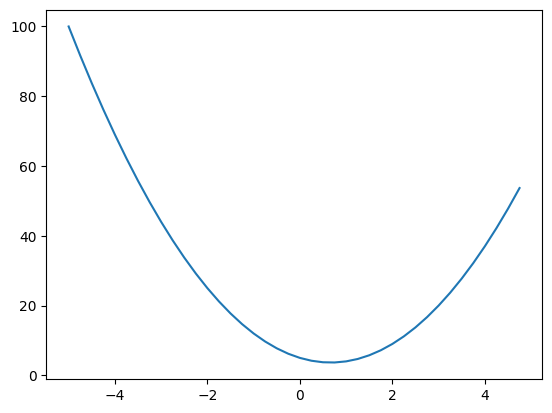

In [6]:
xs = np.arange(-5,5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

> What is the derivative of this function at any single input point x?

One option is to apply all the derivative rules to write out the full expression of $\frac{df}{dx}(x)$.

But we are not going to do that because in neural networks no one writes the full expression of the derivative of a neural network. That would be a massive with tens of thousands of terms!

For now we will go by the definition of the derivate.

$$L = \lim_{{h \to 0}} \frac{f(a + h) - f(a)}{h}$$

In [7]:
h = 0.01
x = 3.0
f(x)

20.0

> Q: What do you expect of $f(x+h)$ when $x=3$? Will it be slightly greater or smaller than f(x)?

----

In [8]:
f(x + h) - f(x) # how much the function responded
(f(x + h) - f(x)) / h # normalize by the run to get the slope

14.029999999999632

this is a numberical approximation so it becomes more exact the smaller h is

In [9]:
h = 0.000000000001
(f(x + h) - f(x)) / h

14.001244608152774

> Q: What do you expect of the derivative at point $x=-3$ now?

----

Finally we have the point where the slope is zero

In [10]:
h = 0.0000001
x = 2/3
(f(x + h) - f(x)) / h

2.9753977059954195e-07

At this point, if we change the input in any direction the function doesn't change

## Let's Get a bit more complex

In [11]:
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


Now i want the derivative of d with respect to a,b and c

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 100000000.0

d1 = a*b + c

# compare with the result after changing one of the parameters by a little bit
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


So we now have some intuition about what the derivative tells us about the function. So let's move on to Neural Networks. 

Neural Networks will have massive mathematical expressions so we are going to build a data structure `Value` that let's us keep track of the operations and that will help us propagate the gradients throughout a mathematical expression.

# Initialization

We want to build the computational graph of any expression

In [12]:
class Value:

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value({self.data})"

In [13]:
a = Value(3)

In [14]:
a

Value(3)

We want to be able to perform simple operations like addition

In [15]:
b = Value(4)

try:
    a + b
except:
    print('Oops, not implemented yet')

Oops, not implemented yet


We define python's addition between objects of our class `Value` by implementing the method `__add__`

In [16]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other: Value):
        return Value(self.data + other.data)

In [17]:
a = Value(3)
b = Value(4)

a + b #a.__add__(b)

Value(7)

yay!

# Exercise 1

Go [here](https://colab.research.google.com/github/samsung-ai-course/6-7-edition/blob/main/Intro%20to%20Deep%20Learning/Building%20Neural%20Networks%20from%20Scratch/Exercise%201%20-%20Implement%20remaining%20operators.ipynb) to jump into exercise 1.

![](media/jump.jpg)

In [ ]:
# paste here solution after exercise is done

---

Let's go back to our expression above

In [18]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d


TypeError: unsupported operand type(s) for *: 'Value' and 'Value'

What we are missing:
> A connection between these expressions that allows us to understand "what `Values` produced these other `Values`"

In [19]:
class Value:

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other), '+')
    
    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')
    
    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')
    

In [20]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
d = a*b + c
d

Value(4.0)

In [21]:
list(d._prev)

[Value(-6.0), Value(10.0)]

In [22]:
a._prev

set()

Now we need a way to visualize these expressions

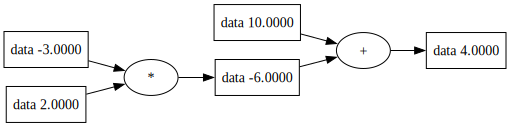

In [23]:
draw_dotV1(d)

Let's add labels!

In [24]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.label}| {self.data})"
    
    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other), '+')
    
    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')
    
    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')
    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
d

Value(d| 4.0)

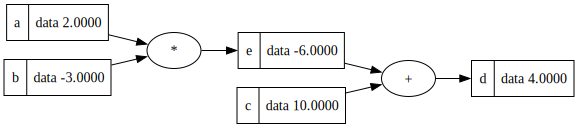

In [25]:
draw_dotV2(d)

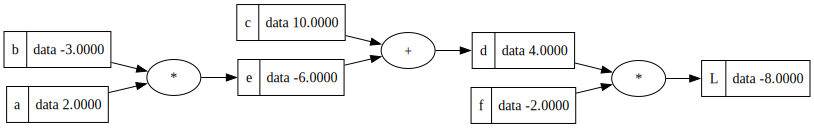

In [26]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a * b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dotV2(L)

- We've got the mathematical expression that produces the single output `L` (forward pass)
- Now we want to do backpropagation: start at the end and compute partial derivatives until we reach the leaf nodes

In NNs we are interested in derivatives of `L` wrt. particular leaf nodes (the model parameters). So each node should store it's derivative wrt. `L`

## Storing gradients

We will create a variable that stores the gradient of L wrt. to the Value object at hand

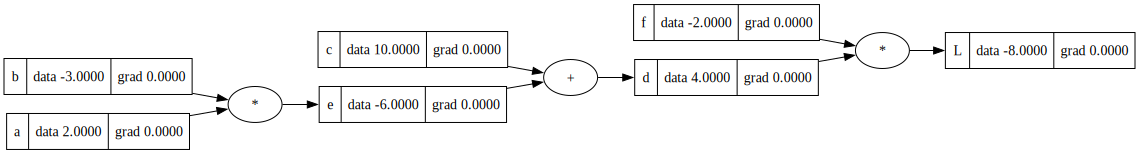

In [27]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other), '+')
    
    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')
    
    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')
    

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'

draw_dotV3(L)

Let's start filling the gradients $\frac{dL}{d\text{node}}$ for all nodes starting from the `L` node

> How much does L change when we change L?

In [28]:
def test_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h

    print((L2 - L1)/h)

test_grad()


0.9999999999976694


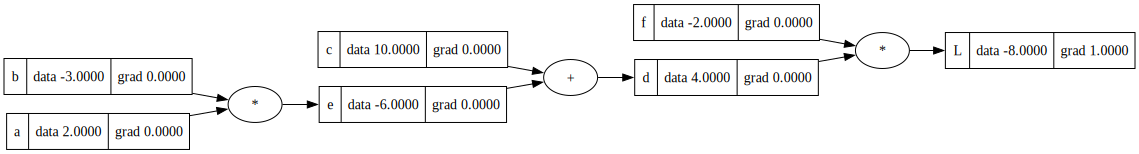

In [29]:
L.grad = 1.0
draw_dotV3(L)

Now let's continue the backpropagation:

1. $\frac{dL}{d\text{d}} = \frac{dL}{d\text{L}} \cdot \frac{dL}{d\text{d}}$

2. $\frac{dL}{df} = \frac{dL}{d\text{L}} \cdot \frac{dL}{d\text{f}}$

In [30]:
# set manually
d.grad = -2.0 * L.grad
f.grad = 4.0 * L.grad

Aaaand we continue:

1. $\frac{dL}{d\text{e}} = \frac{dL}{d\text{d}} \cdot \frac{dd}{d\text{e}}$

2. $\frac{dL}{dc} = \frac{dL}{d\text{d}} \cdot \frac{dd}{d\text{c}}$

In [31]:
# set manually
e.grad = 1 * d.grad
c.grad = 1 * d.grad

## Exercise: fill out the remaining gradients 

1. $\frac{dL}{da}$

2. $\frac{dL}{db}$

In [ ]:
# Exercise
a.grad = #...
b.grad = #...

In [67]:
draw_dotV3(L)

confirm these are correct using `test_grad` function

In [ ]:
def test_grad():
    h = 0.0001

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a') 
    a.data = a.data + h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print((L2 - L1)/h)

test_grad()


----

Here's what've we've done manually:
1. Started from the output node
2. compute partial derivatives to the child nodes
3. do this recursively until we reach the leaf nodes
4. accumulate all partial derivatives (by multiplication) as we go to always have $\frac{dL}{d\text{node}}$


This is what's called `backpropagation`

> Q: What happens to `L` if we now update all leaf nodes by a little bit in the direction of the gradient wrt `L`?

In [ ]:
L

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

# We want to build MLPs

![](https://miro.medium.com/v2/resize:fit:563/1*4_BDTvgB6WoYVXyxO8lDGA.png)

1. They contain addition and multiplication operations
2. They also contain activation functions

![](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

So let's start

# Exercise 1.5

Implement the board's network (2 features, linear combination to "n")

In [ ]:
# inputs are: x1, x2
#...
# n = ...

draw_dotV3(n)

What's missing? The `activation function`

In [ ]:
try: 
    o = n.tanh()
except:
    raise NotImplementedError('Need to implement tanh method in our Value data structure')

Let's implement tanh!

In [257]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other: Value):
        return Value(self.data + other.data, (self,other), '+')
    
    def __mul__(self, other: Value):
        return Value(self.data * other.data, (self,other), '*')

    def __sub__(self, other: Value):
        return Value(self.data - other.data, (self,other), '-')
    
    def __truediv__(self, other: Value):
        return Value(self.data / other.data, (self,other), '/')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out 

In [ ]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # here it is!!
draw_dotV3(o)


Let's start backpropagation!

In [261]:
o.grad = 1.0

what's the derivative of a tanh wrt. its input?
[wikipedia](https://pt.wikipedia.org/wiki/Tangente_hiperbólica)

In [262]:
# Exercise
#n.grad =

In [ ]:
draw_dotV3(o)

In [264]:
# now compute the grads for all the nodes
x1w1x2w2.grad = #...
b.grad = # ...

x1w1.grad = # ...
x2w2.grad = # ...

x2.grad = # ...
w2.grad = # ...

x1.grad = # ...
w1.grad = # ...

In [69]:
#draw_dotV3(o)

----

Okay! We've successfully done backprop manually! Now this is very cumbersome process to do manually so let's add the necessary logic to do this automatically!

In [70]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._backward = lambda: None # this method does the chain rule and stores how it transmits the output's gradient into the inputs' gradient of the current node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other: Value):
        out =  Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other: Value):
        out =  Value(self.data * other.data, (self,other), '*')
        return out

    def __sub__(self, other: Value):
        out = Value(self.data - other.data, (self,other), '-')
        return out
    
    def __truediv__(self, other: Value):
        out = Value(self.data / other.data, (self,other), '/')
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        return out 

## Exercise 2: implement backwards for multiplication, sub and division

Go [here](https://colab.research.google.com/github/samsung-ai-course/6-7-edition/blob/main/Intro%20to%20Deep%20Learning/Building%20Neural%20Networks%20from%20Scratch/Exercise%202%20-%20Implement%20remaining%20backward.ipynb) to jump into exercise 2.

![](media/jump.jpg)

In [282]:
# copy paste the solution here after the exercise is done

----

Going back to our logistic regression (now with backpropagation!)

In [294]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # here it is!!


In [ ]:
draw_dotV3(o)

In [ ]:
o.grad = 1.0
o._backward()
draw_dotV3(o)

In [286]:
n._backward()
# check draw_dot

In [287]:
b._backward()
# check draw_dot


In [288]:
x1w1x2w2._backward()
# check draw_dot

In [289]:
x1w1._backward()
x2w2._backward()
# check draw_dot

In [ ]:
draw_dotV3(o)

----

So let's automate this!

1. We want to call ._backward() from end of the graph to the start. Never call on a node where the parent node hasn't yet been called.


answer: `topological sort!`

In [ ]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)
print(topo)

Let's reset the gradients and call backward now on this list starting from the `o` node

In [295]:
topo = []
visited = set()
build_topo(o)

o.grad = 1.0
for node in reversed(topo):
    node._backward()

In [ ]:
draw_dotV3(o)

Let's hide this functionality

In [72]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # at initialization every Value does not impact the output
        self._backward = lambda: None # this method does the chain rule and stores how it transmits the output's gradient into the inputs' gradient of the current node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data - other.data, (self,other), '-')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += -1.0 * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other: Value):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, (self,other), '/')

        def _backward():
            self.grad += (1.0 / other.data) * out.grad
            other.grad += (-self.data / (other.data**2)) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out 
    
    def __pow__(self, other : int):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out



In [298]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label='o' # here it is!!

In [299]:
o.backward()

In [ ]:
draw_dotV3(o)

![](media/pika.jpg)

## Edge cases: Why do we accumulate gradients?

### Example 1

In [ ]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
b.backward()
draw_dotV3(b)

### Example 2

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b
d.label = 'd'
e = a + b
e.label = 'e'
f = d * e
f.label = 'f'

f.backward()

draw_dotV3(f)


# Building our Neural Network

In [76]:
class Module:

    def zero_grad(self):
        """
        # we always want to be able to reset the gradients for the next iteration of training
        """
        # what is this for?
        #

    def parameters(self):
        return []

In [ ]:
import random

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        """
        Expects x to be an iterable with the same dimensions as the number of inputs (nin), and weights (w).
        """
        act = sum((wi*xi for wi,xi in zip(self.w, x)),self.b)
        return act.tanh() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'tanh' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

x = [2.1, 3.1]
n = Neuron(2)
n(x)


We want to be able to build a layer of neurons

In [79]:
class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

In [ ]:
x = [2.1, 3.1]
n = Layer(2,3)
n(x)

An MLP is a bunch of layers together

In [81]:
nin = 2
nouts = [4,10]

In [82]:
class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [8,4,1])
n(x)

----

# Can our network learn?

In [84]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]  # desired targets

In [85]:
# input data is 3d so let's choose 3 as input size and do 2 hidden layers
n = MLP(3, [4,4,1])

In [ ]:
# let's try to see the initial predictions first
ypred = [n(x) for x in xs]
ypred


In [ ]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]

In [ ]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)],Value(0))
loss

In [89]:
loss.backward() # perform backwards pass

In [ ]:
draw_dotV3(loss)

In [ ]:
n.layers[0].neurons[0].w[0].grad # this weight is going to update in the opposite direction

Let's update the parameters to reduce the loss!

In [92]:
for p in n.parameters():
    p.data -= 0.01 * p.grad


compute loss again

In [ ]:
ypred = [n(x) for x in xs]
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)],Value(0))
loss

It's lower!

Do we want to keep training?

In [94]:
# reset the gradients every iteration! (one of the most common DL silent bugs)

for p in n.parameters():
    p.grad = 0.0

----

We can automate this as well, let's say we want to train for 20 epochs

In [ ]:
for epoch in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    # mse loss
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)],Value(0))

    # backward pass
    for p in n.parameters():
        p.grad = 0 # reset first
    loss.backward()

    # update model parameters
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(epoch, loss.data)

# Let's try to fit some quadratic function

In [96]:
from sklearn.model_selection import train_test_split

In [ ]:
def quadratic_func(x):
    return np.power(x,2) + 3*x

xs = np.linspace(-5,5,40)
ys = quadratic_func(xs)
plt.scatter(xs,ys)

In [98]:
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

## Exercise: use an MLP to fit this data

1. Use one hidden layer, but you can decide how many neurons in that layer
2. Plot the loss along the epochs
3. Plot the model's prediction and datapoints along the epochs (to see visually how close it is modelling the data)

----

# Future Work

1. Implement other activations to `Value` such as ReLu and sigmoid
2. Implement classification capability by allowing a sigmoid at the final layer
3. Try this dataset on the Iris dataset. choose 2 classes from there and try to fit that data